In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [70]:
import tensorflow as tf
import numpy as np
import torch
import math
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import matplotlib.pyplot as plt

In [165]:
data = '/content/drive/MyDrive/trajectories_imu/df_RGC.pkl'
with open(data, 'rb') as file:
    data = pickle.load(file)

label = '/content/drive/MyDrive/trajectories_imu/labels_RGC.pkl'
with open(label, 'rb') as file:
    labels = pickle.load(file)

labels = labels.astype(float)/100
labels = labels.values

In [166]:
print(data.shape,len(labels))

(102, 3, 1127) 102


In [167]:
def build_model(lr=0.001, units_gru=64, units_gru_2=32, units_dense = 16):
    model = tf.keras.Sequential()

    # Capa GRU 1 para procesar las secuencias temporales
    model.add(layers.GRU(units_gru, return_sequences=True, input_shape=(data.shape[1], data.shape[2]))) # 64 unidades GRU

    # Capa GRU 2 para capturar características a diferentes escalas
    model.add(layers.GRU(units_gru_2, return_sequences=False))

    # Capa totalmente conectada para procesar características a nivel de píxeles
    model.add(layers.Dense(units_dense, activation='ReLU')) #relu per evitar la saturacio de gradients

    # Capa totalmente conectada final con función de activación sigmoide
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

    return model

In [168]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)
print(y_train.shape, y_test.shape)

def create_dataloader(X_train, y_train, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)
    return dataset

(81,) (21,)


# HYPERPARAMETER TUNNING

In [169]:
param_grid = {
    'lr': [0.001, 0.01, 0.1],  # Tasa de aprendizaje
    'units_gru': [32, 64, 128],  # Unidades en la capa GRU
    'units_gru_2': [16, 32, 64],  # Unidades en la segunda capa GRU,
    'units_dense': [8, 16, 32]
}

keras_model = KerasRegressor(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament

#cross-validation
grid_search = RandomizedSearchCV (keras_model, param_grid, cv=3)
grid_result = grid_search.fit(X_train, y_train)

<ipython-input-169-2e4cd3ea0017>:8: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_model = KerasRegressor(build_fn=build_model, verbose=0) #especificar el contstructor del model + si volem imprimir el progres de l'entrenament


In [170]:
#evaluacio del model amb els millor hyperparametres
best_model = grid_result.best_estimator_.model
test_loss, test_mae = best_model.evaluate(X_test, y_test)
print("\nPérdida en el conjunto de prueba:", test_loss)
print("Error absoluto medio en el conjunto de prueba:", test_mae)

1/1 [==============================] - 2s 2s/step - loss: 0.1972 - mae: 0.4026

Pérdida en el conjunto de prueba: 0.19724512100219727
Error absoluto medio en el conjunto de prueba: 0.40259119868278503


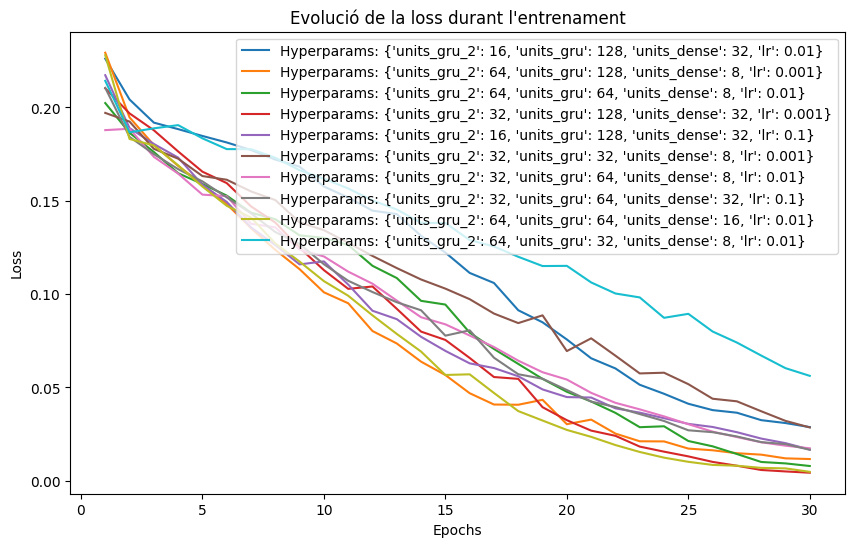

In [171]:
# Obtener el historial de entrenamiento para cada modelo en la búsqueda en cuadrícula
loss_history = []
for params, cv_results in zip(grid_result.cv_results_['params'], grid_result.cv_results_['mean_test_score']):
    model = build_model(**params)  # Construir el modelo con los hiperparámetros específicos
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    history = model.fit(X_train, y_train, batch_size=32, epochs=30, verbose=0)  # Entrenar el modelo
    loss_history.append(history.history['loss'])  # Guardar la pérdida

# Hacer la gráfica de la evolución de la pérdida para cada combinación de hiperparámetros
plt.figure(figsize=(10, 6))
for i, loss in enumerate(loss_history):
    plt.plot(range(1, len(loss)+1), loss, label=f"Hyperparams: {grid_result.cv_results_['params'][i]}")

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

In [172]:
print("Millors hyperparàmetres:")
print(grid_result.best_params_)

print("\nMillor score:")
print(grid_result.best_score_)

Millors hyperparàmetres:
{'units_gru_2': 32, 'units_gru': 128, 'units_dense': 32, 'lr': 0.001}

Millor score:
-0.19182187815507254


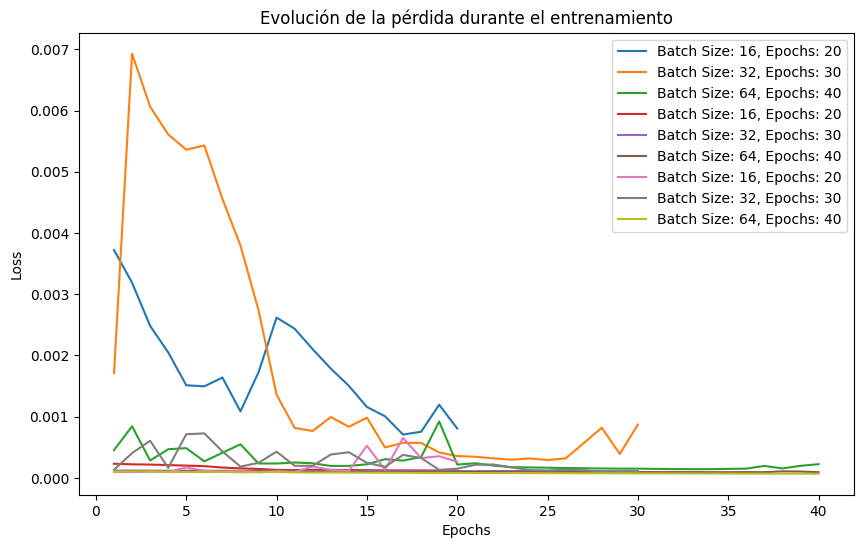

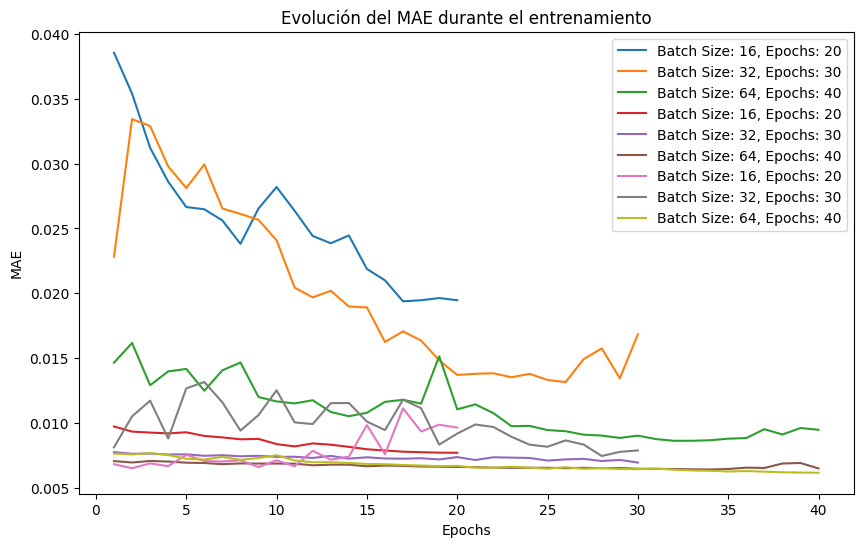

In [175]:
# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

#Diferents valors a provar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

loss_values = []
mae_values = []

for batch_size in batch_sizes:
    for epochs in epochs_values:
        train_dataset = create_dataloader(X_train, y_train, batch_size)
        history = model.fit(train_dataset, epochs=epochs, verbose=0)

        loss_values.append(history.history['loss'])
        mae_values.append(history.history['mae'])

#Graficar l'evolució de les proves (loss)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(loss_values[i])+1), loss_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evolució de la loss durant l\'entrenament')
plt.legend()
plt.show()

#Graficar l'evolució de les proves (mae)
plt.figure(figsize=(10, 6))
for i, (batch_size, epochs) in enumerate(zip(batch_sizes * len(epochs_values), epochs_values * len(batch_sizes))):
    label = f"Batch Size: {batch_size}, Epochs: {epochs}"
    plt.plot(range(1, len(mae_values[i])+1), mae_values[i], label=label)

plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.title('Evolució del MAE durant l\'entrenament')
plt.legend()
plt.show()


In [176]:
# Define la lista de batch y epochs a probar
batch_sizes = [16, 32, 64]
epochs_values = [20, 30, 40]

best_mae = float('inf')
best_batch_size = None
best_epochs = None

# Emmagatzemar els hyperparàmetres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']

# Realiza la búsqueda de hiperparámetros
for batch_size in batch_sizes:
    for epochs in epochs_values:
        model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)
        model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=0)

        # Evalúa el modelo en el conjunto de prueba
        _, test_mae = model.evaluate(X_test, y_test, verbose=0)

        # Almacena los resultados
        if test_mae < best_mae:
            best_mae = test_mae
            best_batch_size = batch_size
            best_epochs = epochs

print("Mejor combinación de hiperparámetros:")
print("Batch size:", best_batch_size)
print("Epochs:", best_epochs)
print("MAE en el conjunto de prueba:", best_mae)

Mejor combinación de hiperparámetros:
Batch size: 64
Epochs: 20
MAE en el conjunto de prueba: 0.43456968665122986


# Model final

In [177]:
#hyperparametres
units_gru_2, units_gru, units_dense, lr = grid_result.best_params_['units_gru_2'], grid_result.best_params_['units_gru'], grid_result.best_params_['units_dense'], grid_result.best_params_['lr']
batch_size = best_batch_size

#creació i compilació model
final_model = build_model(lr=lr, units_gru=units_gru, units_gru_2=units_gru_2, units_dense=units_dense)

# Creació del DataLoader
train_dataset = create_dataloader(X_train, y_train, batch_size)

#entrenament del model amb els hyperparametres trobats
final_model.fit(train_dataset, epochs=best_epochs, verbose=1)

#Evaluació amb el conjunt test
test_dataset = create_dataloader(X_test, y_test, batch_size)
test_loss, test_mae = final_model.evaluate(test_dataset, verbose=0)
print(f"Loss en conjunto de prueba: {test_loss}")
print(f"MAE en conjunto de prueba: {test_mae}")

Epoch 1/20
2/2 [==============================] - 4s 23ms/step - loss: 0.2572 - mae: 0.4916
Epoch 2/20
2/2 [==============================] - 0s 15ms/step - loss: 0.1932 - mae: 0.3949
Epoch 3/20
2/2 [==============================] - 0s 15ms/step - loss: 0.1810 - mae: 0.3773
Epoch 4/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1765 - mae: 0.3901
Epoch 5/20
2/2 [==============================] - 0s 21ms/step - loss: 0.1682 - mae: 0.3770
Epoch 6/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1612 - mae: 0.3488
Epoch 7/20
2/2 [==============================] - 0s 15ms/step - loss: 0.1646 - mae: 0.3368
Epoch 8/20
2/2 [==============================] - 0s 16ms/step - loss: 0.1501 - mae: 0.3326
Epoch 9/20
2/2 [==============================] - 0s 15ms/step - loss: 0.1466 - mae: 0.3448
Epoch 10/20
2/2 [==============================] - 0s 15ms/step - loss: 0.1420 - mae: 0.3370
Epoch 11/20
2/2 [==============================] - 0s 14ms/step - loss: 0.1349 

In [182]:
y_pred = final_model.predict(X_test)
for i in range(len(y_test)):
  print(y_test[i],"                   ",y_pred[i])

1/1 [==============================] - 0s 44ms/step
0.0                     [0.4200386]
0.8569766235351562                     [0.70775867]
1.0                     [0.5500467]
0.9870536804199219                     [0.8174473]
0.6351990127563476                     [0.15450896]
1.0                     [0.18357892]
0.0                     [0.7308531]
1.0                     [0.37060562]
0.9744159698486328                     [0.19915903]
0.0                     [0.74289066]
1.0                     [0.8449986]
0.0                     [0.4200386]
0.6449063873291015                     [0.86919564]
1.0                     [0.8455396]
0.8045121002197265                     [0.7716315]
0.9029817199707031                     [0.8382428]
1.0                     [0.76339257]
0.0                     [0.7555563]
0.0                     [0.40642688]
0.0                     [0.70995444]
1.0                     [0.4094068]
